In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python import utils as putils

from pipeline.python.classifications import decode_by_ncells as dc
from pipeline.python.classifications import decode_utils as decutils
from pipeline.python.retinotopy import fit_2d_rfs as fitrf

from matplotlib.lines import Line2D
import matplotlib.patches as patches

In [2]:
%matplotlib notebook

In [3]:
def check_old_naming(animalid, session, fov, experiment='blobs', traceid='traces001',
                decode_type='single_cells', sub_dir='dff-nstds_stimulus', C_str='tuneC',
                rootdir='/n/coxfs01/2p-data'):
    
    res_files = glob.glob(os.path.join(rootdir, animalid, session, fov, 
                            'combined_%s_static' % experiment, 'traces', '%s*' % traceid, 
                            'decoding', decode_type, sub_dir, '*%s*.pkl' % C_str))
    for r in res_files:
        curr_dir, fname = os.path.split(r)
        if fname.startswith('single_cells_'):
            new_name = fname.split('single_cells_')[-1]
            os.rename(r, os.path.join(curr_dir, new_name))
    return


In [4]:
def plot_true_and_shuffled_distns(meandf, metric='heldout_test_score', return_scores=True, ax=None):
    '''
    Takes 
    '''
    
    tru_df = meandf[meandf['condition']=='data']
    shu_df = meandf[meandf['condition']=='shuffled']

    mean_score = tru_df[metric].mean()
    shuffled_score = shu_df[metric].mean()
    score_percentile = np.mean(mean_score < shu_df[metric])
    #print('%.2f, %.2f' % (mean_score, shuffled_score))

    # PLOT
    if ax is None:
        fig, ax = pl.subplots()
    sns.distplot(tru_df[metric], ax=ax, color='m')
    sns.distplot(shu_df[metric], ax=ax, color='k')
    ax.axvline(x=mean_score, linestyle=':', color='m')
    ax.axvline(x=shuffled_score, linestyle=':', color='k')
    
    if return_scores:
        return ax, mean_score, score_percentile
    else:
        return ax
    
    

In [5]:

def stripplot_by_area(metric, data_df, ax=None, area_colors=None, size=5,
                     visual_areas=['V1', 'Lm', 'Li', 'Ll'], scale=2, bar=True, annotate=True, xytext=(0, -10)):
    if ax is None:
        fig, ax = pl.subplots()
        
    if area_colors is None:
        cols = sns.color_palette('colorblind', n_colors=len(visual_areas))
        area_colors = dict((v, c) for v, c in zip(visual_areas, cols))    
    
    if bar or annotate:
        sns.barplot(x='visual_area',  y=metric, data=data_df, ax=ax,
                           order=visual_areas,
                           zorder=0, edgecolor='none', facecolor='none', color='none')
        data_df.apply(aggr.annotateBars, ax=ax, fontsize=12, fontcolor='k', xytext=xytext)

        
    sns.stripplot(x='visual_area',  y=metric, data=data_df, ax=ax,
               order=visual_areas, hue='visual_area',
               zorder=1, size=2, palette=area_colors)

    sns.pointplot(x='visual_area',  y=metric, data=data_df, ax=ax, join=False,
               order=visual_areas, markers='_', color='k', # palette=area_colors,
               scale=1, zorder=1000)
    
    return ax


In [130]:
def single_cell_results_dir(animalid, session, fov, experiment, traceid='traces001',
                            C_value=None, response_type='dff', responsive_test='nstds', trial_epoch='stimulus', 
                            rootdir='/n/coxfs01/2p-data'):
    sub_dir = '%s-%s_%s' % (response_type, responsive_test, trial_epoch)

    C_str = 'tuneC' if C_value is None else 'C%.2f' % C_value
    check_old_naming(animalid, session, fov, experiment=experiment, traceid=traceid,
                     decode_type='single_cells', sub_dir=sub_dir, C_str=C_str)
    
    src_dir = glob.glob(os.path.join(rootdir, animalid, session, fov, 
                            'combined_%s_static' % experiment, 'traces', '%s*' % traceid, 
                            'decoding', 'single_cells', sub_dir))[0] #, '*%s*.pkl' % C_str))
    
    result_id = '%s_%s' % (sub_dir, C_str)

    return src_dir, result_id
    
def get_single_cell_files(animalid, session, fov, experiment, traceid='traces001',
                               C_value=None, response_type='dff', responsive_test='nstds',
                               trial_epoch='stimulus', visual_area=None, roi_list=None,
                               rootdir='/n/coxfs01/2p-data'):
    
    src_dir, result_id = single_cell_results_dir(animalid, session, fov, experiment, traceid=traceid,
                            C_value=C_value, response_type=response_type, responsive_test=responsive_test, 
                            trial_epoch=trial_epoch)
    
    C_str = 'tuneC' if C_value is None else 'C%.2f' % C_value
    
    result_fpaths=[]
    missing_fpaths=[]
    if roi_list is None and visual_area is None:
        result_fpaths = glob.glob(os.path.join(src_dir, '*%s*.pkl' % C_str))
    else:
        if roi_list is None:
            result_fpaths =  glob.glob(os.path.join(src_dir, '%s_%s*.pkl' % (visual_area, C_str)))
        else:
            tmp_fns = [os.path.join(src_dir, '%s_%s__%03d.pkl' % (visual_area, C_str, int(rid+1))) \
                                         for rid in roi_list]
            for c in tmp_fns:
                if not os.path.exists(c):
                    missing_fpaths.append(c)
                else:
                    result_fpaths.append(c)
                    
    if verbose:
        print("(%s, %s) Found %i. Missing %i." % (session, animalid, len(result_fpaths), len(missing_fpaths)))
    
    return result_fpaths, missing_fpaths, result_id

    
            
def load_cell_results_from_fov(animalid, session, fov, experiment, traceid='traces001',
                               C_value=None, response_type='dff', responsive_test='nstds',
                               trial_epoch='stimulus', visual_area=None, roi_list=None,
                               rootdir='/n/coxfs01/2p-data', verbose=False):
    '''
    From running batch, slurm/decode_by_ncells.py (Set analysis_type='single_cells'),
    load all the cells' results.
    '''
    roidf=None
    missing_rois=None
    result_id=None
    
    result_fns, missing_fns, result_id = get_single_cell_files(animalid, session, fov, experiment, traceid=traceid,
                               C_value=C_value, response_type=response_type, responsive_test=responsive_test,
                               trial_epoch=trial_epoch, visual_area=visual_area, roi_list=roi_list)
    
    if roi_list is not None:
        #print("Found %i of %i roi results" % (len(result_fns), len(roi_list)))
        #if len(missing_fns)>0:
        missing_rois = [int(os.path.splitext(os.path.split(f)[-1])[0].split('_')[-1])-1 for f in missing_fns]
        
    rlist=[]
    for c in result_fns:
        with open(c, 'rb') as f:
            res = pkl.load(f)
        res['iteration'] = res.index.tolist()
        res = res.reset_index(drop=True).sort_values(by='iteration')
        rlist.append(res)
        
    if len(rlist)>0:
        roidf = pd.concat(rlist, axis=0)
        
    return roidf, missing_rois, result_id


In [7]:
# Set colors
visual_areas, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()


# Dataset info

In [8]:
analysis_type='single_cells'
n_iterations=100

overlap_thr=None #0.5
n_processes=1
responsive_test='nstds'
experiment='blobs'
C_value=None
has_rfs = overlap_thr is not None

options=['-E', experiment, '-R', responsive_test, '-n', n_processes, '-N', n_iterations, '-o', overlap_thr, '-C', C_value]

opts = dc.extract_options(options)
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

# Set responsivitiy params
traceid = opts.traceid #'traces001'
response_type = opts.response_type #'dff'
responsive_test = opts.responsive_test #'nstds' # 'nstds' #'ROC' #None
responsive_thr = float(opts.responsive_thr) #10
n_stds = None if responsive_test=='ROC' else 2.5 #None
response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 

# Create data ID for labeling figures with data-types
stim_filterby = None #'first'
has_gratings = experiment!='blobs'
g_str = 'hasgratings' if has_gratings else 'blobsonly'
filter_str = 'filter_%s_%s' % (stim_filterby, g_str)
response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 
data_id = '|'.join([traceid, filter_str, response_str])
print(data_id)


# Choose what type classifier to make
m0=int(opts.class_a) #0
m100=int(opts.class_b) #106
n_iterations=int(opts.n_iterations) #100 
n_processes=int(opts.n_processes) #2
overlap_thr = None if opts.overlap_thr is None else float(opts.overlap_thr) 


# Set classifier training params
C_value = opts.C_value
do_cv = C_value is None
C_value = None if do_cv else float(opts.C_value)
print('Classify Morph %i v %i\nN=%i iterations (%i proc), overlap=%s, C=%s' \
      % (m0, m100, n_iterations, n_processes, str(overlap_thr), str(C_value)))


traces001|filter_None_blobsonly|dff_nstds-thr-10.00
Classify Morph 0 v 106
N=100 iterations (1 proc), overlap=None, C=None


In [9]:
train_str = 'by_singlecells_iter-%i' % (n_iterations)

# Set colors
visual_area, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()


# Output dir

In [10]:
#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')

dst_dir = os.path.join(aggregate_dir, 'decoding', 'single_cells')
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
    print(dst_dir)

# Get metadata for experiment type

In [11]:
#### Get metadata for experiment type
sdata = aggr.get_aggregate_info(traceid=traceid) #, fov_type=fov_type, state=state)

# sdata_exp = sdata[sdata['experiment']==experiment]
#sdata_exp['visual_area'].unique()

edata, expmeta = aggr.experiment_datakeys(experiment='blobs', has_rfs=has_rfs, 
                            has_gratings=has_gratings, stim_filterby=None,
                                experiment_only=False)
print(edata['visual_area'].unique())

Segmentation: missing 9 dsets
Segmentation: missing 9 dsets
Segmentation: missing 9 dsets
[u'V1' u'Ll' u'Lm' u'Li']


In [12]:
edata.head()

,experiment,visual_area,datakey,animalid,fov,session,fovnum
157,blobs,V1,20190420_JC076_fov1,JC076,FOV1_zoom2p0x,20190420,1
158,retino,V1,20190420_JC076_fov1,JC076,FOV1_zoom2p0x,20190420,1
159,rfs,V1,20190420_JC076_fov1,JC076,FOV1_zoom2p0x,20190420,1
160,blobs,V1,20190501_JC076_fov1,JC076,FOV1_zoom2p0x,20190501,1
161,retino,V1,20190501_JC076_fov1,JC076,FOV1_zoom2p0x,20190501,1


In [32]:
#### Load neural responses
trial_epoch= 'plushalf' #'stimulus'
responsive_test='nstds' #'roc'
responsive_thr=10 #10 #0.05
response_type='dff'


#### Check for equal trial counts
_, all_cells, MEANS, SDF = aggr.get_source_data(experiment, equalize_now=True, 
                                       response_type=response_type,
                                       responsive_test=responsive_test, 
                                       responsive_thr=responsive_thr, 
                                       trial_epoch=trial_epoch, check_configs=True, 
                                       zscore_now=True, return_configs=True, images_only=False) 
visual_areas = ['V1', 'Lm', 'Li', 'Ll']
all_cells = all_cells[all_cells['visual_area'].isin(visual_areas)]
sdf_master = aggr.get_master_sdf(images_only=True)

all_cells.groupby(['visual_area']).count()


Segmentation: missing 9 dsets
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_plushalf.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [-15   0], y: [-5  0]
---equalizing now---
Segmentation: missing 9 dsets
SDF, images_only=False (excluding dsetes: [])
Segmentation: missing 3 dsets


,cell,fov,animalid,session,datakey,fovnum
visual_area,,,,,,
Li,1142,1142,1142,1142,1142,1142
Ll,293,293,293,293,293,293
Lm,1970,1970,1970,1970,1970,1970
V1,2089,2089,2089,2089,2089,2089


In [33]:
overlap_thr=None
has_retino=False

has_rfs = (has_retino is False) and (overlap_thr is not None)
print('retino:', has_retino, 'rfs:', has_rfs)

match_distns = False
match_str = 'match-Li-distn' if match_distns else ''
stack_neuraldf = analysis_type=='by_ncells'

#### Load RFs
NEURALDATA=None; RFDATA=None;
if has_rfs:
    print("~~~~~~~~~~~~~~~~Loading RFs~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    rf_fit_desc = fitrf.get_fit_desc(response_type=response_type)
    reliable_str = 'reliable' if reliable_only else ''
    #rf_str = 'match%s_%s' % (experiment, reliable_str)
    # Get position info for RFs
    rfdf = aggr.load_rfdf_and_pos(dsets, rf_filter_by=None,
                                    reliable_only=True, traceid=traceid)
    # RF dataframes
    NEURALDATA, RFDATA, assigned_cells = aggr.get_neuraldata_and_rfdata(all_cells, rfdf, MEANS,
                                            stack=stack_neuraldf)
elif has_retino:
    print("~~~~~~~~~~~~~~~~Loading Retinotopy Bar ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    #edata = sdata[sdata['experiment'].isin(['retino'])]
    #assigned_rois, missing_ = seg.get_cells_by_area(edata, return_missing=True)
    retino_cells = aggr.aggregate_responsive_retino(all_cells, traceid=traceid,
                                    mag_thr=retino_mag_thr, pass_criterion=retino_pass_criterion,
                                    verbose=False, create_new=True)
    #cells = retino_cells[retino_cells['visual_area'].isin(visual_areas)]
    print("Missing %i retino analyses" % len(missing_))
    #for r in missing_:
    #    print(r)
    NEURALDATA = aggr.get_neuraldata(retino_cells, MEANS, stack=True)
    assigned_cells = aggr.cells_in_experiment_df(retino_cells, NEURALDATA)

else:
    print("~~~~~~~~~~~~~~~~No Receptive Fields~~~~~~~~~~~~~~~~~~~~~~~~~")
    # EXP dataframes
    NEURALDATA = aggr.get_neuraldata(all_cells, MEANS, stack=stack_neuraldf)
    assigned_cells = aggr.cells_in_experiment_df(all_cells, NEURALDATA)

('retino:', False, 'rfs:', False)
~~~~~~~~~~~~~~~~No Receptive Fields~~~~~~~~~~~~~~~~~~~~~~~~~


In [34]:
assigned_cells.groupby(['visual_area']).count()

,cell,fov,animalid,session,datakey,fovnum
visual_area,,,,,,
Li,1142,1142,1142,1142,1142,1142
Ll,293,293,293,293,293,293
Lm,1970,1970,1970,1970,1970,1970
V1,2089,2089,2089,2089,2089,2089


In [35]:
remove_too_few=False
min_ncells=5

if has_rfs:
    print("~~~~~~~~~~~~~~~~Calculating overlaps (thr=%.2f)~~~~~~~~~~~~~" % overlap_thr)
    # Calculate overlap with stimulus
    stim_overlaps = rfutils.calculate_overlaps(RFDATA, experiment=experiment)
    # Filter cells
    globalcells, cell_counts = aggr.get_pooled_cells(stim_overlaps,
                                        remove_too_few=remove_too_few,
                                        overlap_thr=0 if overlap_thr is None else overlap_thr,
                                        min_ncells=min_ncells)
else:
    globalcells, cell_counts = aggr.global_cells(assigned_cells,
                                        remove_too_few=remove_too_few,
                                        min_ncells=min_ncells, return_counts=True)
if globalcells is None:
    print("NO CELLS. Exiting.")
    #return None

print("@@@@@@@@ cell counts @@@@@@@@@@@")
print(cell_counts)


Assigned visual areas: [u'Li' u'Ll' u'Lm' u'V1']
@@@@@@@@ cell counts @@@@@@@@@@@
{u'V1': 2089, u'Ll': 293, u'Lm': 1970, u'Li': 1142}


In [51]:
#### Get final cells dataframe
CELLS = globalcells.copy()
CELLS['cell'] = globalcells['dset_roi']

print("------------------------------------")
print("Final cell counts:")
CELLS[['visual_area', 'datakey', 'dset_roi', 'cell']].drop_duplicates().groupby(['visual_area']).count()

------------------------------------
Final cell counts:


,datakey,dset_roi,cell
visual_area,,,
Li,1142,1142,1142
Ll,293,293,293
Lm,1970,1970,1970
V1,2089,2089,2089


In [37]:
#### Setup output dirs
results_prefix = analysis_type #set_results_prefix(analysis_type=analysis_type)
if has_retino:
    overlap_str = 'retino'
else:
    overlap_str = 'noRF' if overlap_thr is None else 'overlap%.1f' % overlap_thr

results_id = dc.create_results_id(prefix=results_prefix,
                        visual_area=None, C_value=C_value, has_retino=has_retino,
                        response_type=response_type, responsive_test=responsive_test,
                        overlap_thr=overlap_thr, trial_epoch=trial_epoch)

print(results_id)

single_cells_None__dff-nstds_noRF__plushalf__tuneC


# Decode

In [22]:
test_split=0.2
cv_nfolds=5
C_value=None

class_a=0
class_b=106


# Aggregate single cell results for 1 FOV

##### Test for 1 fov

In [282]:
# animalid = 'JC091'
# session = '20190602'
# fovnum=1
# datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
# visual_area='Li'
# fov = 'FOV%i_zoom2p0x' % fovnum

# roi_list = CELLS[(CELLS['visual_area']==visual_area) & (CELLS['datakey']==datakey)]['cell'].unique()

# # curr_ncells = globalcells[(globalcells['datakey']==datakey) & (globalcells['visual_area']==visual_area)].shape
# roidf, missing, results_id = load_cell_results_from_fov(animalid, session, fov, experiment, traceid=traceid,
#                                    C_value=None, trial_epoch=trial_epoch,
#                                    response_type=response_type, responsive_test=responsive_test,
#                                    rootdir=rootdir, roi_list=roi_list, visual_area=visual_area)
# curr_ncells = roidf.shape[0]
# metainfo = {'datakey': datakey, 'visual_area': visual_area}
# roidf = putils.add_meta_to_df(roidf, metainfo)

# print("Missing %i result files" % len(missing))
# print('%s' % datakey, missing)

In [283]:
# metric = 'heldout_test_score'

# means_by_cell = roidf.groupby(['cell', 'condition']).mean().reset_index()
# curr_ncells = len(means_by_cell['cell'].unique())

# # PLOT
# fig, ax = pl.subplots()
# ax, mean_score, score_percentile = plot_true_and_shuffled_distns(means_by_cell, ax=ax,
#                                                                  metric=metric, return_scores=True)
# ax.set_title("p=%.2f [%s] (%s, n=%i cells)" \
#              % (score_percentile, visual_area, datakey, curr_ncells))

# Aggregate all single cell results

In [129]:
#overlap_thr = None
#C_value=None
#trial_epoch = 'plushalf'
# ----------------------------------------

#print(results_id)
missing_files = dict((k, dict()) for k in visual_areas)
r_list=[]
# for (visual_area, animalid, session, fovnum, datakey), g \
#     in dsets.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'datakey']):
for (visual_area, animalid, session, fovnum, datakey), g \
        in CELLS.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'datakey']):
        
    roidf, missing, tmpid = load_cell_results_from_fov(animalid, session, 
                            'FOV%i_zoom2p0x' % fovnum, experiment,
                             C_value=C_value, trial_epoch=trial_epoch,
                             response_type=response_type, responsive_test=responsive_test,
                             visual_area=visual_area, roi_list=g['cell'].values, verbose=False)
    if missing is not None and len(missing)>0:
        missing_files[visual_area].update({datakey: np.array(missing)})
        
    if roidf is None:
        print("[%s] %s - No cells." % (visual_area, datakey))
        continue
        
    if len(g['cell'].unique()) != len(roidf['cell'].unique()):
        print('Unequal', visual_area, datakey)
        
    metainfo = {'datakey': datakey, 'visual_area': visual_area}
    roidf = putils.add_meta_to_df(roidf, metainfo)
    r_list.append(roidf)

singledf = pd.concat(r_list, axis=0)

Found 26. Missing 0.
Found 14. Missing 0.
Found 0. Missing 47.
[Li] 20190314_JC070_fov1 - No cells.
Found 96. Missing 0.
Found 84. Missing 0.
Found 13. Missing 0.
Found 132. Missing 0.
Found 26. Missing 0.
Found 15. Missing 11.
('Unequal', u'Li', '20190422_JC076_fov1')
Found 137. Missing 0.
Found 81. Missing 0.
Found 137. Missing 0.
Found 122. Missing 0.
Found 66. Missing 0.
Found 51. Missing 0.
Found 18. Missing 0.
Found 49. Missing 0.
Found 17. Missing 0.
Found 143. Missing 0.
Found 117. Missing 0.
Found 33. Missing 0.
Found 89. Missing 0.
Found 55. Missing 0.
Found 0. Missing 6.
[Lm] 20190327_JC073_fov1 - No cells.
Found 181. Missing 0.
Found 115. Missing 0.
Found 97. Missing 0.
Found 131. Missing 0.
Found 228. Missing 0.
Found 193. Missing 0.
Found 178. Missing 0.
Found 152. Missing 0.
Found 107. Missing 0.
Found 162. Missing 0.
Found 170. Missing 0.
Found 105. Missing 0.
Found 0. Missing 1.
[Lm] 20191111_JC120_fov1 - No cells.
Found 50. Missing 0.
Found 179. Missing 0.
Found 0. Mi

In [131]:
# datakey='20190512_JC083_fov1'
# visual_area = 'V1'
# g = CELLS[(CELLS['visual_area']==visual_area) & (CELLS['datakey']==datakey)].copy()
# roi_list = g['cell'].values

# session, animalid, fovnum = aggr.split_datakey_str(datakey)
# fov = 'FOV%i_zoom2p0x' % fovnum
# src_dir0, result_id0 = single_cell_results_dir(animalid, session, fov, experiment, traceid=traceid,
#                             C_value=C_value, response_type=response_type, responsive_test=responsive_test, 
#                             trial_epoch=trial_epoch)
# print(src_dir0, result_id0)

In [133]:
# C_str = 'tuneC' if C_value is None else 'C%.2f' % C_value
# tmp_fns = [os.path.join(src_dir0, '%s_%s__%03d.pkl' % (visual_area, C_str, int(rid+1))) \
#                                      for rid in roi_list]
# missing_fpaths=[]
# result_fpaths=[]
# for c in tmp_fns:
#     if not os.path.exists(c):
#         missing_fpaths.append(c)
#     else:
#         result_fpaths.append(c)
# print(len(missing_fpaths), len(result_fpaths))

# fov = 'FOV%i_zoom2p0x' % fovnum
# result_fns, missing_fns, result_id = get_single_cell_files(animalid, session, fov, experiment, traceid=traceid,
#                            C_value=C_value, response_type=response_type, responsive_test=responsive_test,
#                            trial_epoch=trial_epoch, visual_area=visual_area, roi_list=roi_list)

# if roi_list is not None:
#     #print("Found %i of %i roi results" % (len(result_fns), len(roi_list)))
#     if len(missing_fns)>0:
#         missing_rois = [int(os.path.splitext(os.path.split(f)[-1])[0].split('_')[-1])-1 for f in missing_fns]

# print(len(missing_fns), len(result_fns))



# roidf, missing, tmpid = load_cell_results_from_fov(animalid, session, 
#                         'FOV%i_zoom2p0x' % fovnum, experiment,
#                          C_value=C_value, trial_epoch=trial_epoch,
#                          response_type=response_type, responsive_test=responsive_test,
#                          visual_area=visual_area, roi_list=g['cell'].values)

# len(missing), roidf is None

In [136]:
pp.pprint(dict((k, v.keys()) for k, v in missing_files.items()))

{   'Li': ['20190422_JC076_fov1', '20190314_JC070_fov1'],
    'Ll': [],
    'Lm': ['20190327_JC073_fov1', '20191111_JC120_fov1'],
    'V1': [   '20190504_JC078_fov1',
              '20190508_JC083_fov1',
              '20190509_JC078_fov1',
              '20190512_JC083_fov1']}


In [139]:
for v, vdict in missing_files.items():
    for d, dlist in vdict.items():
        print('[%s] %s (missing %i)' % (v, d, len(dlist)))

[V1] 20190504_JC078_fov1 (missing 37)
[V1] 20190508_JC083_fov1 (missing 29)
[V1] 20190509_JC078_fov1 (missing 44)
[V1] 20190512_JC083_fov1 (missing 46)
[Lm] 20190327_JC073_fov1 (missing 6)
[Lm] 20191111_JC120_fov1 (missing 1)
[Li] 20190422_JC076_fov1 (missing 11)
[Li] 20190314_JC070_fov1 (missing 47)


In [143]:
# Average bootstrap iterations together
itermean = singledf.groupby(['visual_area', 'datakey', 'cell', 'condition']).mean().reset_index()

# Get counts
counts_by_fov = itermean[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                        .groupby(['visual_area', 'datakey']).count().reset_index()
counts_by_fov.groupby(['visual_area']).sum()

,cell
visual_area,
Li,1084
Ll,293
Lm,1963
V1,1933


## Filter cells that don't pass 

In [144]:
p_thr=0.01
metric='heldout_test_score'
# Use bootstrap distn to calculate percentiles
s_=[]
for (visual_area, datakey, rid), d_ in singledf.groupby(['visual_area', 'datakey', 'cell']):
                            
    mean_score = d_[d_['condition']=='data'][metric].mean()
    percentile = np.mean(mean_score < d_[d_['condition']=='shuffled'][metric])
    n_iterations = d_[d_['condition']=='data'].shape[0]
    s = pd.Series({'visual_area': visual_area, 'datakey': datakey, 'cell': rid, 
                   'mean_score': mean_score, 'percentile': percentile, 'n_iterations': n_iterations})
    s_.append(s)
    
scores_by_cell = pd.concat(s_, axis=1).T.reset_index(drop=True)

# Filter
pass_scores = scores_by_cell[scores_by_cell['percentile']<p_thr].copy()
pass_scores['mean_score'] = pass_scores['mean_score'].astype(float)

pass_scores.groupby(['visual_area']).mean()

,mean_score
visual_area,
Li,0.636030
Ll,0.549167
Lm,0.626713
V1,0.631243


In [145]:
above_chance = True

filter_str = 'abovechance%.2f' % p_thr if above_chance else 'nopercentile'

if above_chance:
    df = pd.concat([itermean[(itermean['visual_area']==visual_area) & (itermean['datakey']==datakey) & (itermean['cell']).isin(g['cell'].unique())] \
            for (visual_area, datakey), g in \
                pass_scores.groupby(['visual_area', 'datakey'])], axis=0).reset_index(drop=True)
    ncells_pass = pass_scores.groupby(['visual_area']).count().reset_index()[['visual_area', 'cell']]
else:
    df = itermean.copy()
    ncells_pass = itermean[itermean['condition']=='data'].groupby(['visual_area']).count().reset_index()[['visual_area', 'cell']]
print(ncells_pass)

  visual_area  cell
0          Li    16
1          Ll     1
2          Lm    35
3          V1    95


In [146]:
# pass_global = pass_scores[pass_scores['visual_area']=='V1'].copy()
# pass_global['global_cell_id'] = np.arange(0, len(pass_global))
# pass_global.sample(24).mean()


In [147]:
pass_scores.groupby(['visual_area']).mean()

,mean_score
visual_area,
Li,0.636030
Ll,0.549167
Lm,0.626713
V1,0.631243


# Save single cells results that pass

In [148]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/single_cells'

In [149]:

if has_retino:
    overlap_str = 'retino'
else:
    overlap_str = 'noRF' if overlap_thr is None else 'overlap%.1f' % overlap_thr
    

In [151]:
tmp_out = os.path.join(dst_dir, 'single_cells_percentiles.pkl')# % overlap_str)
with open(tmp_out, 'wb') as f:
    pkl.dump(scores_by_cell, f, protocol=pkl.HIGHEST_PROTOCOL)
    
print(tmp_out)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/single_cells/single_cells_percentiles.pkl


<IPython.core.display.Javascript object>


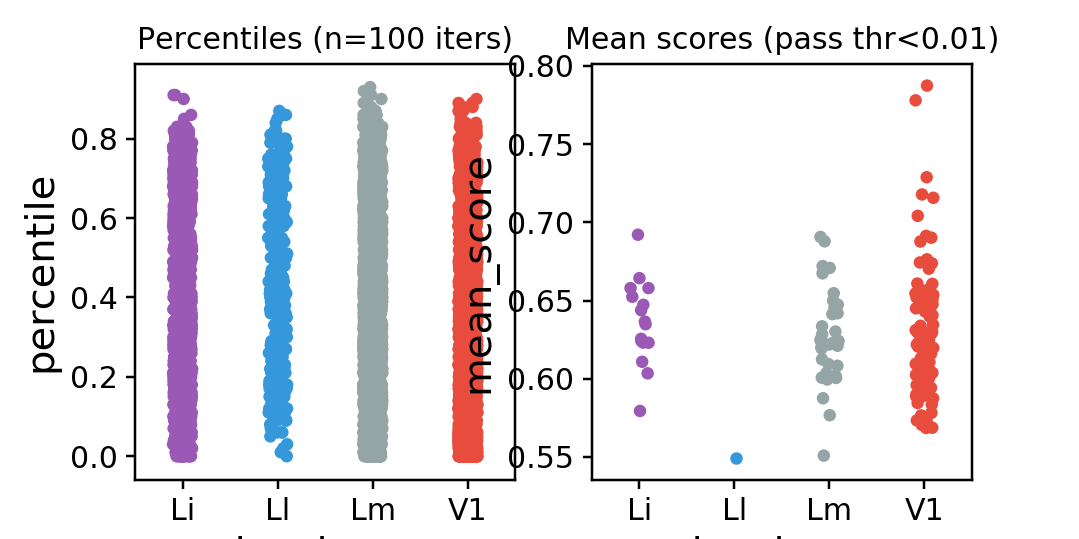

  visual_area  cell
0          Li    16
1          Ll     1
2          Lm    35
3          V1    95


In [76]:
fig, axn = pl.subplots(1,2, figsize=(6, 3))

ax=axn[0]
ax.set_title('Percentiles (n=%i iters)' % n_iterations)
sns.stripplot(x='visual_area', y='percentile', data=scores_by_cell, ax=ax)

ax=axn[1]
ax.set_title('Mean scores (pass thr<%.2f)' % p_thr) # % n_iterations)
sns.stripplot(x='visual_area', y='mean_score', data=pass_scores, ax=ax)

print(ncells_pass)


In [77]:
scores_by_cell.groupby(['visual_area']).count().reset_index()[['visual_area', 'cell']]

,visual_area,cell
0,Li,1084
1,Ll,293
2,Lm,1963
3,V1,1933


In [66]:
meandf[(meandf['condition']=='data') & (meandf['visual_area']=='Li')].shape

NameError: name 'meandf' is not defined

In [391]:
min_ncells=0
curr_dkeys = counts_by_fov[counts_by_fov['cell']>=min_ncells]['datakey'].unique()
all_dkeys = counts_by_fov['datakey'].unique()
print("%i of %i dkeys pass (min_ncells=%i)" % (len(curr_dkeys), len(all_dkeys), min_ncells))

32 of 32 dkeys pass (min_ncells=0)


<IPython.core.display.Javascript object>


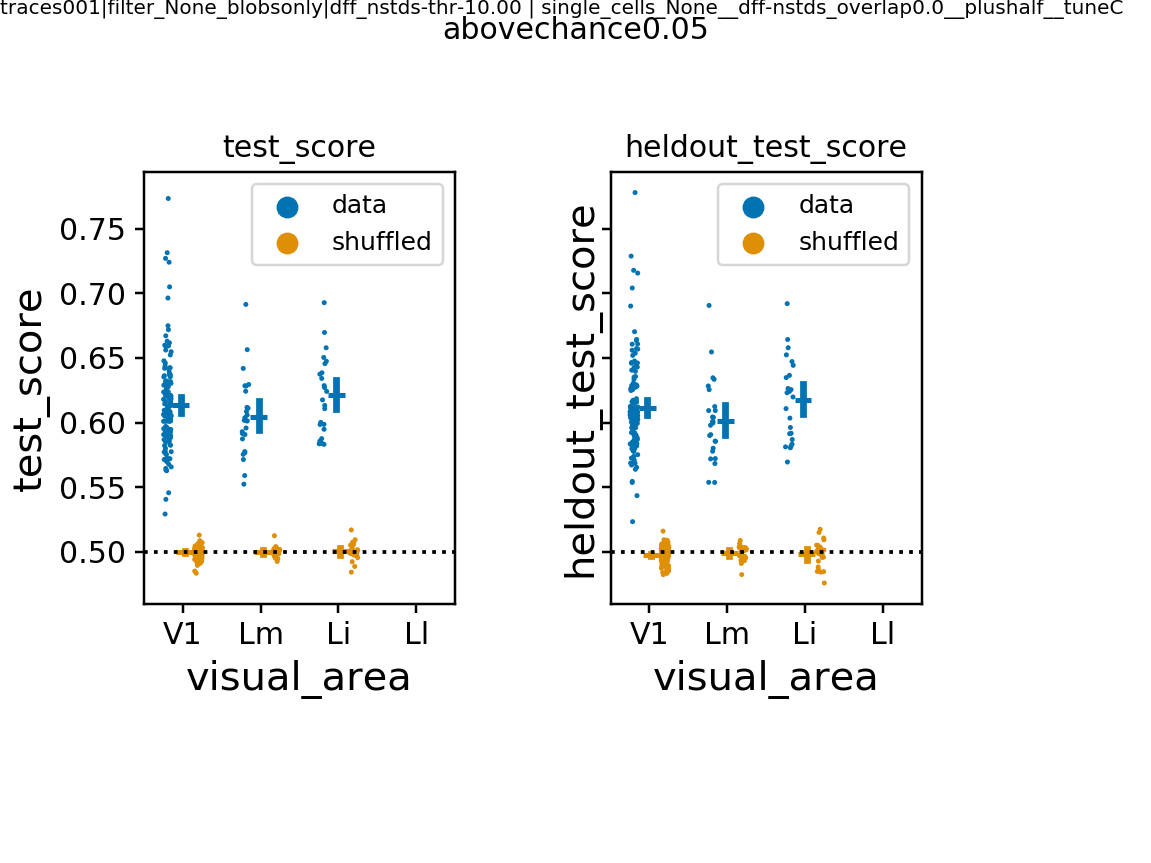

Text(0.5,0.98,u'abovechance0.05')

In [392]:
xdf = df[(df['datakey'].isin(curr_dkeys))]# & ~(df['datakey'].isin(ign))]
meandf = xdf.groupby(['visual_area', 'datakey', 'cell', 'condition']).mean().reset_index()

fig, axn = pl.subplots(1, 2, sharey=True)
ax=axn[0]
metric='test_score'
ax.set_title(metric)
sns.stripplot(x='visual_area',  y=metric, data=meandf, ax=ax,
               hue='condition', dodge=True, palette='colorblind',
               order=visual_areas, size=2, zorder=0)
sns.pointplot(x='visual_area',  y=metric, data=meandf, ax=ax,
               hue='condition', dodge=True, join=False,
               order=visual_areas, markers='_', palette='colorblind')
h, l = ax.get_legend_handles_labels()
ax.legend(h[0:2], l[0:2])
ax.axhline(y=0.5, color='k', ls=':')


ax=axn[1]
metric='heldout_test_score'
ax.set_title(metric)
sns.stripplot(x='visual_area',  y=metric, data=meandf, ax=ax,
               hue='condition', dodge=True, palette='colorblind',
               order=visual_areas, size=2, zorder=0)
sns.pointplot(x='visual_area',  y=metric, data=meandf, ax=ax,
               hue='condition', dodge=True, join=False,
               order=visual_areas, markers='_', palette='colorblind')
h, l = ax.get_legend_handles_labels()
ax.legend(h[0:2], l[0:2])
ax.axhline(y=0.5, color='k', ls=':')


putils.label_figure(fig, '%s | %s' % (data_id, results_id))
pl.subplots_adjust(bottom=0.3, wspace=0.5, right=0.8, top=0.8)
pl.suptitle(filter_str)

In [393]:
# meandf[(meandf['condition']=='shuffled') & (meandf[metric]<=0.476)].groupby(['visual_area', 'datakey']).mean()

#['datakey'].unique()
means_by_fov = meandf.groupby(['visual_area', 'datakey', 'condition']).mean().reset_index()
#means_by_fov#[means_by_fov[metric]<=0.476]

<IPython.core.display.Javascript object>


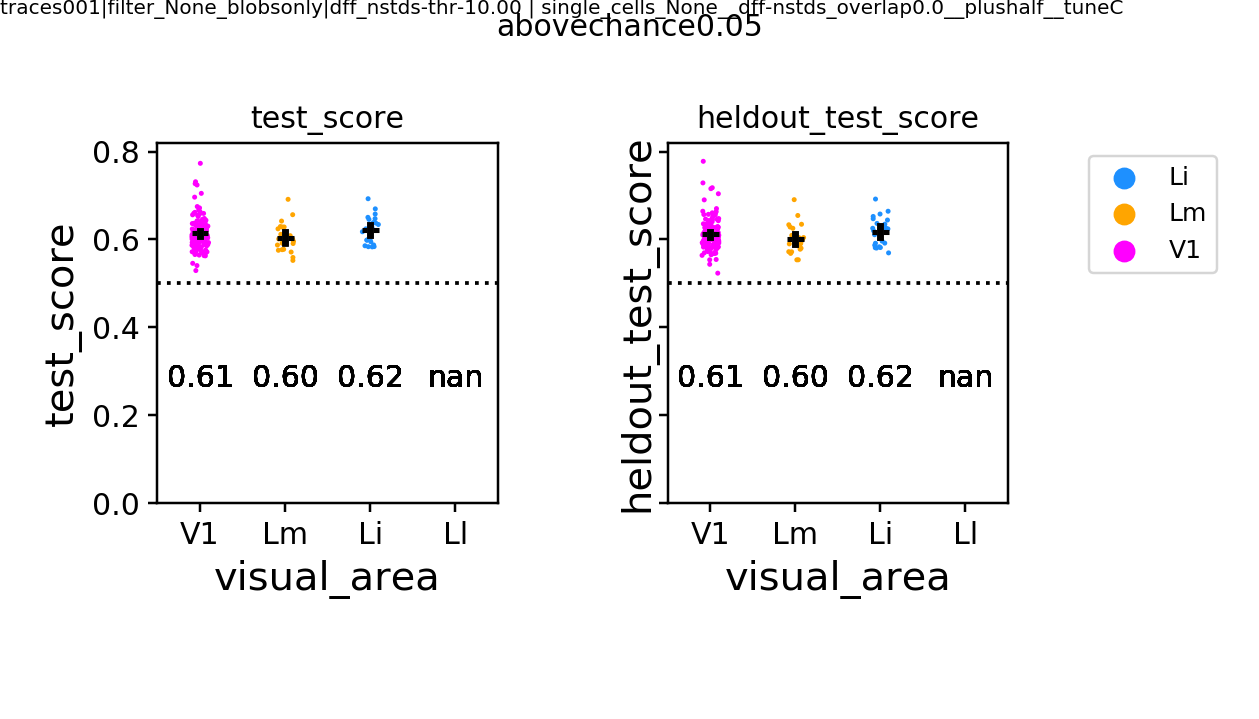

Text(0.5,0.98,u'abovechance0.05')

In [394]:
curr_metric = 'test_score'
xdf = df[(df['datakey'].isin(curr_dkeys))]# & ~(singledf['datakey'].isin(ign))]
meandf = xdf.groupby(['visual_area', 'datakey', 'cell', 'condition']).mean().reset_index()
data_df = meandf[meandf['condition']=='data'].copy()


fig, axn = pl.subplots(1, 2, sharey=True, figsize=(7,4))
ax=axn[0]
metric='test_score' #curr_metric
ax.set_title(metric)
ax = stripplot_by_area(metric, data_df, ax=ax, area_colors=area_colors, 
                       size=2, bar=True, annotate=True, xytext=(0,50))

#### Label
if 'test_score' in metric:
    #ax.set_ylim([0.4, 1])
    ax.axhline(y=0.5, color='k', ls=':')


ax.legend_.remove()


ax=axn[1]
metric='heldout_%s' % curr_metric
ax.set_title(metric)
ax = stripplot_by_area(metric, data_df, ax=ax, area_colors=area_colors, 
                       size=2, bar=True, annotate=True, xytext=(0,50))

ax.legend(bbox_to_anchor=(1.2, 1))
if 'test_score' in metric:
    #ax.set_ylim([0.4, 1])
    ax.axhline(y=0.5, color='k', ls=':')


putils.label_figure(fig, '%s | %s' % (data_id, results_id))
pl.subplots_adjust(bottom=0.3, wspace=0.5, right=0.8, top=0.8)
pl.suptitle(filter_str)

In [369]:
means_by_fov = meandf.groupby(['visual_area', 'datakey', 'condition']).mean().reset_index()


#### Compare scores by FOV

V1    9
Lm    3
Li    2
Name: visual_area, dtype: int64


<IPython.core.display.Javascript object>


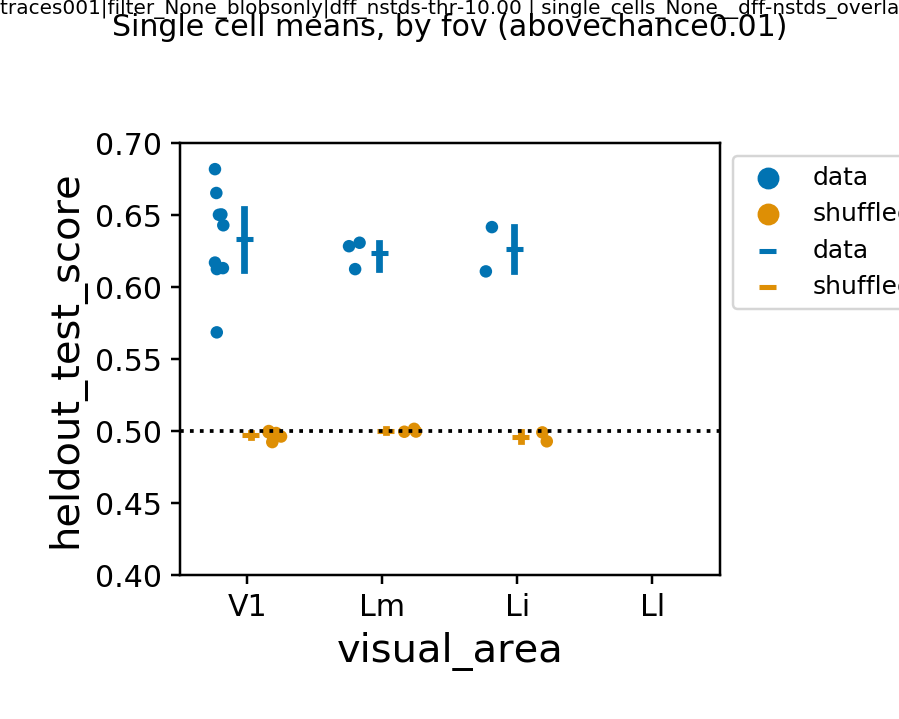

********* [heldout_test_score] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.345 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.345 (fdr_bh), reject H0=False
[('Lm', 'Li')] p=0.386 (fdr_bh), reject H0=False
****************************


In [376]:
metric = 'heldout_test_score'
#metric = 'test_score'
multi_comp_test='fdr_bh'
means_by_fov = meandf.groupby(['visual_area', 'datakey', 'condition']).mean().reset_index()

print(means_by_fov[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts())
      
fig, ax = pl.subplots( sharey=True, figsize=(5,4))
sns.stripplot(x='visual_area',  y=metric, data=means_by_fov, ax=ax,
               hue='condition', dodge=True, palette='colorblind',
               order=visual_areas, size=5, zorder=0)
sns.pointplot(x='visual_area',  y=metric, data=means_by_fov, ax=ax,
               hue='condition', dodge=True, join=False,
               order=visual_areas, markers='_', palette='colorblind')
h, l = ax.get_legend_handles_labels()
ax.legend(h[0:2], l[0:2])
ax.axhline(y=0.5, color='k', ls=':')


#### Stats
statsresults, ax = aggr.plot_mannwhitney(means_by_fov[means_by_fov['condition']=='data'], 
                            metric=metric, multi_comp_test=multi_comp_test, 
                            ax=ax, y_loc=0.6, offset=0.01)
ax.set_ylim([0.4, 0.7])
ax.legend(bbox_to_anchor=(1.4, 1))


putils.label_figure(fig, '%s | %s' % (data_id, results_id))
pl.subplots_adjust(bottom=0.3, wspace=0.5, right=0.8, top=0.8)
pl.suptitle('Single cell means, by fov (%s)' % filter_str)
pl.subplots_adjust(left=0.2, top=0.8, bottom=0.2)

In [357]:
means_by_fov[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts() #count()

V1    9
Lm    3
Li    2
Name: visual_area, dtype: int64

In [358]:

means_by_fov.groupby(['condition', 'visual_area']).mean()

cell          C  fit_time  heldout_MI  \
condition visual_area                                                
data      Li           108.611111  10.981620  0.001288    0.043220   
          Lm           120.428571   7.441943  0.001213    0.043400   
          V1           133.727778  11.247261  0.001581    0.053861   
shuffled  Li           108.611111  13.409375  0.001239    0.015167   
          Lm           120.428571  12.583047  0.001198    0.022144   
          V1           133.727778  13.210597  0.001731    0.031960   

                       heldout_aMI  heldout_log2MI  heldout_test_score  \
condition visual_area                                                    
data      Li              0.050405        0.062353            0.626212   
          Lm              0.050702        0.062612            0.623828   
          V1              0.066405        0.077706            0.633500   
shuffled  Li              0.008830        0.021881            0.495928   
          Lm              0.019021        0.031947            0.500201   
          V1              0.034477        0.046108            0.497006   

                       iteration  n_cells    n_trials       randi  score_time  \
condition visual_area                                                           
data      Li                49.5      1.0  295.000000  5174.49000    0.000366   
          Lm                49.5      1.0  296.666667  4743.19000    0.000388   
          V1                49.5      1.0  307.777778  5030.01654    0.000442   
shuffled  Li                49.5      1.0  295.000000  5174.49000    0.000355   
          Lm                49.5      1.0  296.666667  4743.19000    0.000396   
          V1                49.5      1.0  307.777778  5030.01654    0.000410   

                       test_score  train_score  
condition visual_area                           
data      Li             0.628061     0.628872  
          Lm             0.629172     0.632074  
          V1             0.635694     0.637317  
shuffled  Li             0.501999     0.518920  
          Lm             0.499955     0.517987  
          V1             0.499186     0.516976

In [359]:
groupdf[groupdf['visual_area']=='Li']['datakey'].unique()

array(['20190602_JC091_fov1', '20190607_JC091_fov1',
       '20190609_JC099_fov1', '20190612_JC099_fov1',
       '20191018_JC113_fov1'], dtype=object)

In [360]:
means_by_fov[means_by_fov['visual_area']=='Li']['datakey'].unique()

array(['20190602_JC091_fov1', '20190607_JC091_fov1'], dtype=object)

In [75]:
# fig, ax = pl.subplots()
# sns.barplot(x='visual_area', y=metric, data=xdf, 
#            facecolor='w', edgecolor=('k', 'k', 'k'), order=visual_areas, ax=ax)
# sns.swarmplot(x='visual_area', y=metric, data=xdf, ax=ax,
#              palette=area_colors,  order=visual_areas,)

# xdf.apply(aggr.annotateBars, ax=ax, fontsize=12, fontcolor='k', xytext=(0, -40))


<IPython.core.display.Javascript object>


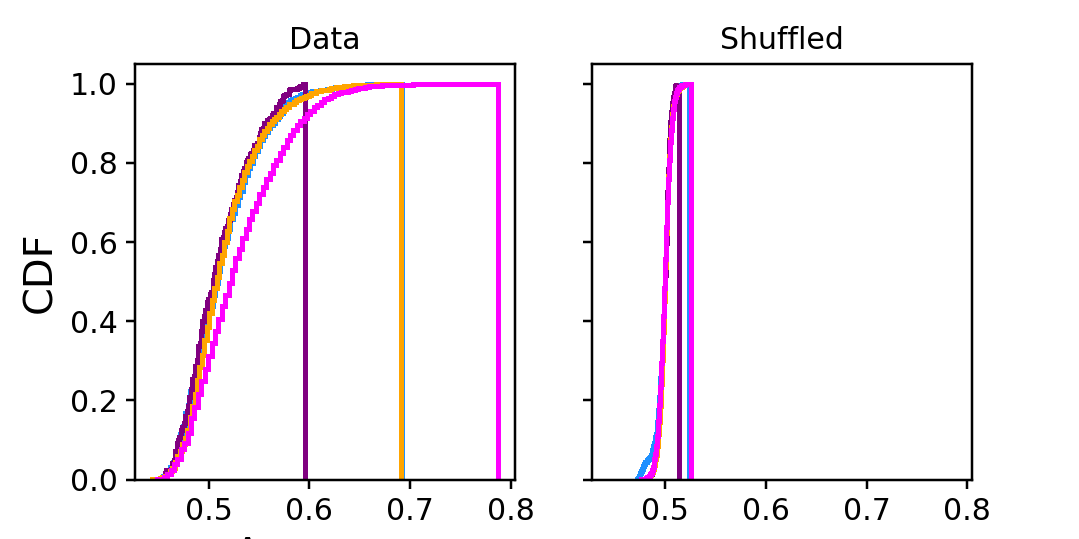

Text(0.5,1,u'Shuffled')

In [47]:
metric='heldout_test_score'
fig, axn = pl.subplots(1,2, figsize=(6,3), sharex=True, sharey=True)

ax=axn[0]
xdf = singledf.copy() #[~(singledf['datakey'].isin(ign))].copy() 
means_by_cell = xdf.groupby(['visual_area', 'datakey', 'cell', 'condition']).mean().reset_index()


for visual_area, vdf in means_by_cell[means_by_cell['condition']=='data'].groupby(['visual_area']):
    n, bins, patches = ax.hist(vdf[metric].values, color=area_colors[visual_area],
                            density=True, histtype='step', cumulative=True,lw=2, bins=100)
ax.set_title('Data')
ax.set_ylabel('CDF')
ax.set_xlabel('Accuracy')

ax=axn[1]
for visual_area, vdf in means_by_cell[means_by_cell['condition']=='shuffled'].groupby(['visual_area']):
    n, bins, patches = ax.hist(vdf[metric].values, color=area_colors[visual_area],
                            density=True, histtype='step', cumulative=True, lw=2, bins=100)
ax.set_title('Shuffled')

<IPython.core.display.Javascript object>


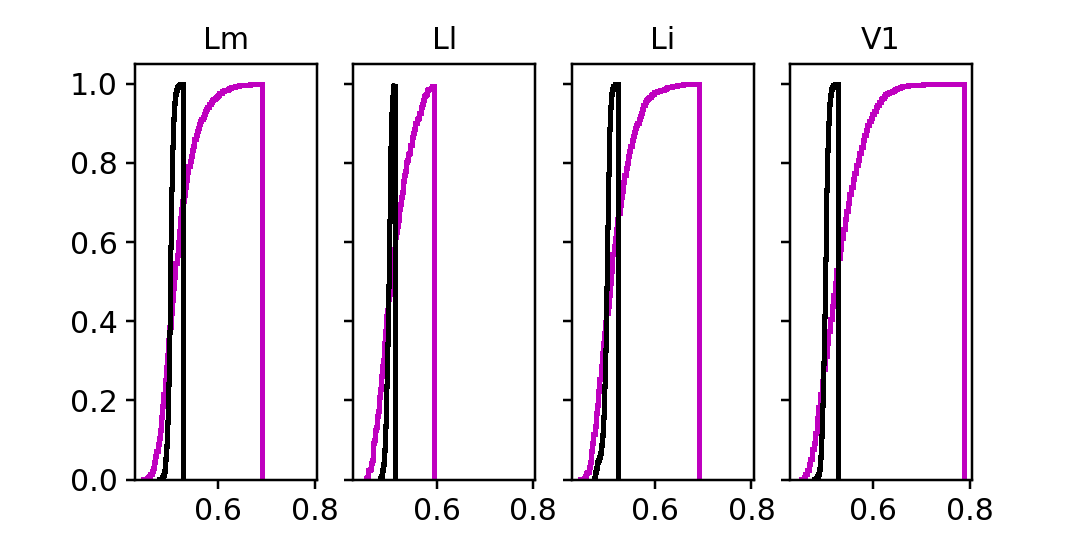

(u'Li', Ks_2sampResult(statistic=0.4716821639898563, pvalue=6.634645922201448e-116))
(u'Ll', Ks_2sampResult(statistic=0.4339080459770115, pvalue=1.948110918915034e-29))
(u'Lm', Ks_2sampResult(statistic=0.4589347934295669, pvalue=1.2588836229409475e-185))
(u'V1', Ks_2sampResult(statistic=0.5853458862054851, pvalue=0.0))


In [46]:
xdf = singledf.copy() #[~(singledf['datakey'].isin(ign))].copy() 
means_by_cell = xdf.groupby(['visual_area', 'datakey', 'cell', 'condition']).mean().reset_index()


fig, axn = pl.subplots(1,4, figsize=(6,3), sharex=True, sharey=True)
for ai, (visual_area, vdf) in enumerate(means_by_cell.groupby(['visual_area'])):
    ax=axn[2-ai]
    d1 = vdf[vdf['condition']=='data'].copy()
    d2 = vdf[vdf['condition']=='shuffled'].copy()
    
    print("%s" % visual_area, spstats.ks_2samp(d1[metric].values, d2[metric].values))
    
    n, bins, patches = ax.hist(d1[metric].values, color='m',
                            density=True, histtype='step', cumulative=True,lw=2, bins=100)
    n, bins, patches = ax.hist(d2[metric].values, color='k',
                            density=True, histtype='step', cumulative=True,lw=2, bins=100)
    
    ax.set_title(visual_area)
    

In [101]:
for visual_area in visual_areas:
    vdf = means_by_cell[means_by_cell['visual_area']==visual_area]

    d1 = vdf[vdf['condition']=='data'].copy()
    d2 = vdf[vdf['condition']=='shuffled'].copy()
    

    print(visual_area, spstats.ks_2samp(d1[metric].values, d2[metric].values))

('V1', Ks_2sampResult(statistic=0.6029106029106028, pvalue=1.3842212387758096e-306))
('Lm', Ks_2sampResult(statistic=0.451198129748685, pvalue=5.527543340959283e-153))
('Li', Ks_2sampResult(statistic=0.4696707105719238, pvalue=3.9504799758792587e-112))
('Ll', Ks_2sampResult(statistic=0.438953488372093, pvalue=8.887476305385559e-30))
